In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50


In [3]:
from types import TracebackType
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
for imaage_batch , labels_batch in dataset.take(1):
    print(imaage_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 2 0 0 0 1 1 0 1 0 2 1 0 1 0 1 2 0 0 0 0 1 1 2 1 1 1 0]


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
(32, 256, 256, 3)
[1 1 2 1 1 1 2 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 2 1]


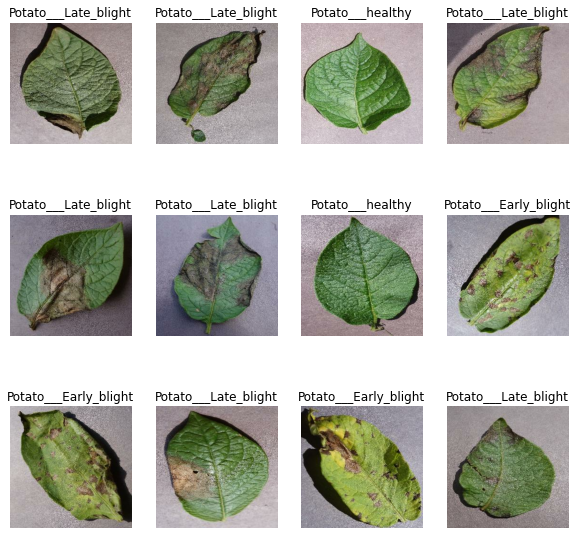

In [6]:
class_names=dataset.class_names
print(class_names)
plt.figure(figsize=(10,10))
for imaage_batch , labels_batch in dataset.take(1):
    print(imaage_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(imaage_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")



In [7]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds=dataset.take(54)
len(train_ds)

54

In [9]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [10]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

**Test/train**

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    assert(train_split+val_split+test_split)==1

    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds =get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Preprocessing**

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**creating model**

In [16]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),


])

model.build(input_shape=input_shape)


In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
from tensorflow.python.ops import losses
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS

)

Epoch 1/50
54/54 [==============================] - 422s 170ms/step - loss: 0.8711 - accuracy: 0.4878 - val_loss: 0.7955 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 6s 104ms/step - loss: 0.6347 - accuracy: 0.7274 - val_loss: 0.6692 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 5s 94ms/step - loss: 0.5285 - accuracy: 0.7922 - val_loss: 0.5763 - val_accuracy: 0.7240
Epoch 4/50
54/54 [==============================] - 5s 94ms/step - loss: 0.4722 - accuracy: 0.8218 - val_loss: 0.5010 - val_accuracy: 0.7656
Epoch 5/50
54/54 [==============================] - 6s 107ms/step - loss: 0.4047 - accuracy: 0.8258 - val_loss: 0.4445 - val_accuracy: 0.7917
Epoch 6/50
54/54 [==============================] - 5s 93ms/step - loss: 0.3114 - accuracy: 0.8681 - val_loss: 0.2917 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 6s 106ms/step - loss: 0.2842 - accuracy: 0.8924 - val_loss: 0.1752 - val_accuracy: 0.9375
Epoch 8

In [20]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 34ms/step - loss: 0.0129 - accuracy: 0.9961


In [21]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


<function matplotlib.pyplot.show(*args, **kw)>

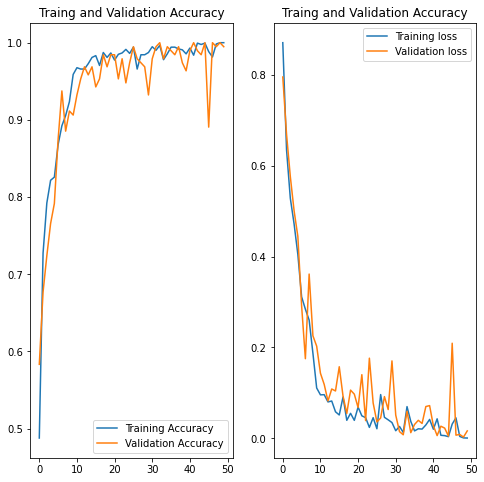

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy ')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traing and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training loss ')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Traing and Validation Accuracy')
plt.show

first image to predict
Actual Label=> Potato___Late_blight
1/1 [==============================] - 0s 35ms/step
prediction Label=? Potato___Late_blight


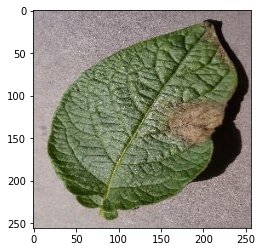

In [30]:
import numpy as np

for images_batch,label_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual Label=>",class_names[labels_batch[0].numpy()])
    batch_prediction = model.predict(images_batch)
    print("prediction Label=?",class_names[np.argmax(batch_prediction[0])])


          
  

In [24]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions= model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)

    return predicted_class,confidence
    


1/1 [==============================] - 0s 22ms/step


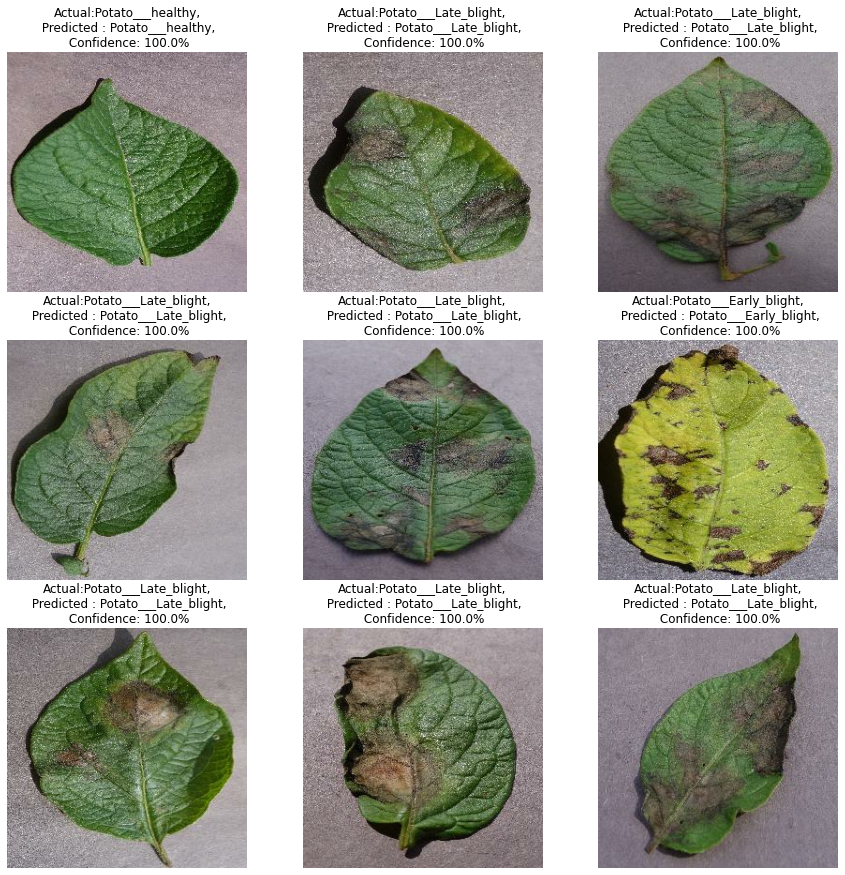

In [34]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted : {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")


In [40]:
model_version =1
model.save(f"/content/drive/MyDrive/Colab Notebooks/models/{model_version}")
